In [1]:
from multiprocessing import Pool
import torch
import numpy as np
import os
from uav_2d_ma_fast import EnvWrapper
# from uav_2d_ma_fast import config
import time
import pickle
import matplotlib.pyplot as plt

In [2]:
N = 16
MODEL_N = 16
EVAL_EPS = 20

In [3]:
N_AGENTS = [N, N]

In [4]:
path = [f'0226/gy2/td3_{MODEL_N}/models/', f'0226/ly2/td3_{MODEL_N}/models/']
# path = [f'final_version_5/gy/td3_{MODEL_N}/models', f'final_version_5/ly/td3_{MODEL_N}/models']

In [5]:
def get_number(model_str):
    return int(model_str.split('/')[-1].split('.')[0])

In [6]:
def get_models_in(path):
    result = []
    rt, pth, files = next(os.walk(path))
    for f in files:
        if get_number(os.path.join(rt, f)) > 40000:
            continue
        result.append(os.path.join(rt, f))
    result.sort(key=lambda x: get_number(x))
    return result

In [7]:
class Actor(torch.nn.Module):

    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.fc0 = torch.nn.Linear(obs_dim, 128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        a = torch.tanh(self.fc2(x))
        return a
    
    def choose_action(self, obs):
        o = torch.tensor(obs).float()
        with torch.no_grad():
            a = self(o)
            a = a.detach().cpu().numpy()
        return a
    
    def load(self, path):
        data = torch.load(path)
        self.load_state_dict(data[0])

In [8]:
def real_done(done):
    for v in done.values():
        if not v:
            return False
    return True

def eval_one_ep(path, n_agents):
    torch.set_num_threads(1)
    env = EnvWrapper(n_agents)
    env.set_global_center('gy' in path)
    actor = Actor(50, 2)
    actor.load(path)
    
    enum_seq = [f'uav_{i}' for i in range(n_agents)]

    states = env.reset()
    done = {n: False for n in enum_seq}
    total_rew = {n: 0 for n in enum_seq}
    dtc = 0

    while not real_done(done):
        actions = {}
        for seq in enum_seq:
            action = actor.choose_action(states[seq])
            actions[seq] = action
        next_states, rewards, done, info = env.step(actions)
        for seq in enum_seq:
            total_rew[seq] += rewards[seq]
        states = next_states
        dtc += env.get_dtc_avg()
        
    ta = env.get_ta()
    die = env.get_die()
    return np.mean(list(total_rew.values())), ta, die, dtc

def eval_n_ep(path, n, n_agents):
    print(f'Eval {path}...')
    result_r = []
    result_ta = []
    result_die = []
    result_dtc = []
    for i in range(n):
        r, ta, die, dtc = eval_one_ep(path, n_agents)
        result_r.append(r)
        result_ta.append(ta)
        result_die.append(die)
        result_dtc.append(dtc)
    rr = np.mean(result_r)
    r_ta = np.mean(result_ta)
    r_die = np.mean(result_die)
    r_dtc = np.mean(result_dtc)
    return rr, r_ta, r_die, r_dtc

In [9]:
eval_tasks = {}
eval_result = {}

with Pool(processes=70) as pool:

    for i, p in enumerate(path):
        models = get_models_in(p)
        eval_tasks[p] = []
        for m in models:
            eval_tasks[p].append(pool.apply_async(eval_n_ep, (m, EVAL_EPS, N_AGENTS[i])))
            
    for k, v in eval_tasks.items():
        eval_result[k] = []
        for t in v:
            eval_result[k].append(t.get())

Eval 0226/gy2/td3_16/models/201.pkl...Eval 0226/gy2/td3_16/models/1.pkl...Eval 0226/gy2/td3_16/models/401.pkl...Eval 0226/gy2/td3_16/models/601.pkl...Eval 0226/gy2/td3_16/models/801.pkl...Eval 0226/gy2/td3_16/models/1001.pkl...Eval 0226/gy2/td3_16/models/2401.pkl...Eval 0226/gy2/td3_16/models/1201.pkl...Eval 0226/gy2/td3_16/models/1401.pkl...Eval 0226/gy2/td3_16/models/1601.pkl...Eval 0226/gy2/td3_16/models/1801.pkl...Eval 0226/gy2/td3_16/models/2001.pkl...Eval 0226/gy2/td3_16/models/2201.pkl...
Eval 0226/gy2/td3_16/models/4401.pkl...Eval 0226/gy2/td3_16/models/2601.pkl...Eval 0226/gy2/td3_16/models/2801.pkl...

Eval 0226/gy2/td3_16/models/3001.pkl...Eval 0226/gy2/td3_16/models/3201.pkl...
Eval 0226/gy2/td3_16/models/3401.pkl...
Eval 0226/gy2/td3_16/models/3601.pkl...Eval 0226/gy2/td3_16/models/4001.pkl...Eval 0226/gy2/td3_16/models/4201.pkl...
Eval 0226/gy2/td3_16/models/3801.pkl...Eval 0226/gy2/td3_16/models/4601.pkl...Eval 0226/gy2/td3_16/models/6401.pkl...Eval 0226/gy2/td3_16/model

0226/gy2/td3_16/models/ MAX: -11.123517959666685 MODEL: 38201
0226/ly2/td3_16/models/ MAX: -28.782410669790767 MODEL: 10801


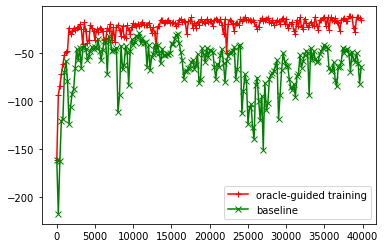

In [10]:
for k, v in eval_result.items():
    if 'gy' in k:
        lbl = 'oracle-guided training'
        marker = 'r+-'
    if 'ly' in k:
        lbl = 'baseline'
        marker = 'gx-'
    models = get_models_in(k)
    numbers = []
    numbers.extend(map(get_number, models))
    rewards = []
    index = min(len(numbers), len(v))
    for i in range(index):
        rewards.append(v[i][0])
    print(f'{k} MAX: {np.max(rewards[:index])} MODEL: {numbers[np.argmax(rewards[:index])]}')
    plt.plot(numbers[:index], rewards, marker, label=lbl)
    # plt.legend()
    # plt.title('Rewards')
    plt.legend()
    plt.savefig(f'{N}_reward.svg')